In [ ]:
#init 

In [2]:
import geopandas as gpd
import pandas as pd

In [28]:
df = pd.read_csv("./villes_france_30000.csv")
villes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
villes.set_crs("EPSG:4326")

,idx,INSEE,nom,latitude,longitude,population,geometry
0,1,75100,Paris,48.867,2.333,2152423,POINT (2.33300 48.86700)
1,2,13200,Marseille,43.300,5.400,800550,POINT (5.40000 43.30000)
2,3,69380,Lyon,45.750,4.850,415487,POINT (4.85000 45.75000)
3,4,31555,Toulouse,43.600,1.433,358688,POINT (1.43300 43.60000)
4,5,6088,Nice,43.700,7.250,342439,POINT (7.25000 43.70000)
...,...,...,...,...,...,...,...
29995,29996,52195,Farincourt,47.700,5.683,68,POINT (5.68300 47.70000)
29996,29997,70090,Boursieres,47.617,6.050,68,POINT (6.05000 47.61700)
29997,29998,54224,Germonville,48.400,6.217,68,POINT (6.21700 48.40000)
29998,29999,73049,Bonvillaret,45.567,6.300,68,POINT (6.30000 45.56700)


In [29]:
from shapely.geometry import Polygon

In [30]:
ile_de_france=Polygon([(2.91, 48.52),(2.91, 49.12),(1.82, 49.12),(1.82, 48.52)])

In [32]:
villes[villes.geometry.within(ile_de_france)]

,idx,INSEE,nom,latitude,longitude,population,geometry
0,1,75100,Paris,48.867,2.333,2152423,POINT (2.33300 48.86700)
34,35,92012,Boulogne-Billancourt,48.833,2.250,101743,POINT (2.25000 48.83300)
37,38,93048,Montreuil,48.867,2.433,94754,POINT (2.43300 48.86700)
39,40,95018,Argenteuil,48.950,2.250,93096,POINT (2.25000 48.95000)
40,41,93066,Saint-Denis,48.933,2.358,89988,POINT (2.35800 48.93300)
...,...,...,...,...,...,...,...
28639,28640,95633,Vaudherland,49.000,2.483,93,POINT (2.48300 49.00000)
28640,28641,77193,Forfry,49.050,2.850,93,POINT (2.85000 49.05000)
29306,29307,95212,Epiais-les-Louvres,49.033,2.550,80,POINT (2.55000 49.03300)
29359,29360,78917,Rhodon,48.717,2.067,79,POINT (2.06700 48.71700)


In [34]:
cities = villes[(~villes.geometry.within(ile_de_france)) | (villes["nom"] == "Paris")]

In [53]:
final_cities=cities[:100]
final_cities

,idx,INSEE,nom,latitude,longitude,population,geometry
0,1,75100,Paris,48.867,2.333,2152423,POINT (2.33300 48.86700)
1,2,13200,Marseille,43.300,5.400,800550,POINT (5.40000 43.30000)
2,3,69380,Lyon,45.750,4.850,415487,POINT (4.85000 45.75000)
3,4,31555,Toulouse,43.600,1.433,358688,POINT (1.43300 43.60000)
4,5,6088,Nice,43.700,7.250,342439,POINT (7.25000 43.70000)
...,...,...,...,...,...,...,...
139,140,58194,Nevers,46.983,3.167,41968,POINT (3.16700 46.98300)
140,141,60159,Compiegne,49.417,2.833,41896,POINT (2.83300 49.41700)
141,142,69290,Saint-Priest,45.692,4.933,41876,POINT (4.93300 45.69200)
142,143,6030,LeCannet,43.567,7.017,41842,POINT (7.01700 43.56700)


<AxesSubplot:>

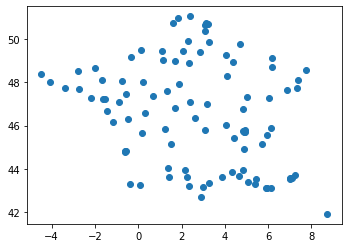

In [54]:
final_cities.plot()

In [57]:
MAX_DIST = 1
graphe = final_cities
g = {nom: {} for nom in graphe.nom}

prev = None
for i in range(len(graphe)):
    dist = graphe.iloc[i+1:].distance(graphe.iloc[i].geometry)
    for j, d in enumerate(dist):
        if d < MAX_DIST:
            g[graphe.iloc[i].nom][graphe.iloc[i + j + 1].nom] = {"weight": d}
            g[graphe.iloc[i + j + 1].nom][graphe.iloc[i].nom] = {"weight": d}

    if (int(i / len(graphe) * 100) % 10 == 0) and (int(i / len(graphe) * 100) != prev):
        prev = int(i / len(graphe) * 100)
        print(str(prev)+"% effectué")

0% effectué
10% effectué
20% effectué
30% effectué
40% effectué
50% effectué
60% effectué
70% effectué
80% effectué
90% effectué


In [58]:
g

{'Paris': {'Beauvais': {'weight': 0.6187535858481976},
  'Mantes-la-Jolie': {'weight': 0.6268269298618255},
  'Compiegne': {'weight': 0.7433034373659284}},
 'Marseille': {'Toulon': {'weight': 0.5635405930365615},
  'Aix-en-Provence': {'weight': 0.23532530675641725},
  'Avignon': {'weight': 0.8731488991002666},
  'LaSeyne-sur-Mer': {'weight': 0.5227705041411548},
  'Arles': {'weight': 0.8502811299799636},
  'Hyeres': {'weight': 0.7399851349858325},
  'Martigues': {'weight': 0.3640054944640268}},
 'Lyon': {'Saint-Etienne': {'weight': 0.5504443659444608},
  'Villeurbanne': {'weight': 0.03712142238653962},
  'Valence': {'weight': 0.8185285578402262},
  'Venissieux': {'weight': 0.07468600939935167},
  'Vaulx-en-Velin': {'weight': 0.08931965069345106},
  'Saint-Priest': {'weight': 0.1012570985165979},
  'Roanne': {'weight': 0.8320636994846001}},
 'Toulouse': {'Montauban': {'weight': 0.42517996189848295},
  'Albi': {'weight': 0.7905555008979437},
  'Castres': {'weight': 0.817},
  'Carcassonne

In [59]:
import networkx as nx
G = nx.from_dict_of_dicts(g)

In [60]:
len(G) #number of edges

100

In [61]:
G.number_of_edges() #number of vertices 

195

In [62]:
list(nx.connected_components(G)) #10 composantes con

[{'Amiens',
  'Beauvais',
  'Boulogne-sur-Mer',
  'Caen',
  'Calais',
  'Chalons-en-Champagne',
  'Charleville-Mezieres',
  'Compiegne',
  'Douai',
  'Dunkerque',
  'Evreux',
  'LeHavre',
  'Lille',
  'Mantes-la-Jolie',
  'Paris',
  'Reims',
  'Roubaix',
  'Rouen',
  'Saint-Quentin',
  'Tourcoing',
  'Troyes',
  "Villeneuve-d'Ascq",
  'Wattrelos'},
 {'Aix-en-Provence',
  'Albi',
  'Annecy',
  'Antibes',
  'Arles',
  'Avignon',
  'Beziers',
  'Cannes',
  'Carcassonne',
  'Castres',
  'Chambery',
  'Grenoble',
  'Hyeres',
  'LaSeyne-sur-Mer',
  'LeCannet',
  'Lyon',
  'Marseille',
  'Martigues',
  'Montauban',
  'Montpellier',
  'Narbonne',
  'Nice',
  'Nimes',
  'Perpignan',
  'Roanne',
  'Saint-Etienne',
  'Saint-Priest',
  'Toulon',
  'Toulouse',
  'Valence',
  'Vaulx-en-Velin',
  'Venissieux',
  'Villeurbanne'},
 {'Belfort', 'Besancon', 'Colmar', 'Mulhouse', 'Strasbourg'},
 {'Angers',
  'Angouleme',
  'Blois',
  'Bourges',
  'Brest',
  'Chateauroux',
  'Cholet',
  'Clermont-Ferrand',